In [1]:
# pylint: disable=line-too-long
from qiskit.algorithms import VQE
from qiskit_nature.algorithms import (GroundStateEigensolver,
                                      NumPyMinimumEigensolverFactory)
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureMoleculeDriver, ElectronicStructureDriverType)
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper
# pylint: enable=line-too-long

import matplotlib.pyplot as plt
import numpy as np
from qiskit_nature.circuit.library import UCCSD, HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP
from qiskit.opflow import TwoQubitReduction
from qiskit import BasicAer, Aer
from qiskit.utils import QuantumInstance
from qiskit.utils.mitigation import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel

/tmp/ipykernel_11853/421762560.py:3: NatureDeprecationWarning: The qiskit_nature.algorithms.excited_state_solvers package is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release. Instead use the qiskit_nature.second_q.algorithms.excited_state_solvers package.
  from qiskit_nature.algorithms import (GroundStateEigensolver,
/tmp/ipykernel_11853/421762560.py:3: NatureDeprecationWarning: The qiskit_nature.algorithms.pes_sampler package is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release . Please refer to 'https://github.com/Qiskit/qiskit-nature/issues/750' for additional information regarding 'extrapolators'.
  from qiskit_nature.algorithms import (GroundStateEigensolver,


In [15]:
def get_qubit_op(geometry, tqr=False):
    # Define Molecule
    molecule = Molecule(
        # Coordinates in Angstrom
        geometry=geometry,
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )

    driver = ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis="sto3g",
        driver_type=ElectronicStructureDriverType.PYSCF)

    # Get properties
    properties = driver.run()
    num_particles = (properties
                        .get_property("ParticleNumber")
                        .num_particles)
    num_spin_orbitals = int(properties
                            .get_property("ParticleNumber")
                            .num_spin_orbitals)

    # Define Problem, Use freeze core approximation, remove orbitals.
    problem = ElectronicStructureProblem(
        driver,
        [FreezeCoreTransformer(freeze_core=True,
                               remove_orbitals=[-3,-2])]) # Might need to change this.

    second_q_ops = problem.second_q_ops()  # Get 2nd Quant OP
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles

    mapper = ParityMapper()  # Set Mapper
    hamiltonian = second_q_ops['ElectronicEnergy'] # Set Hamiltonian. # I had to change this to second_q_ops['ElectronicEnergy'],
                                                   # from second_q_ops[0].
    # Do two qubit reduction
    converter = QubitConverter(mapper,two_qubit_reduction=tqr)
    if(tqr): reducer = TwoQubitReduction(num_particles)
    qubit_op = converter.convert(hamiltonian)
    if(tqr): qubit_op = reducer.convert(qubit_op)

    print(f'Qubit op. = {qubit_op}.')

    return qubit_op, num_particles, num_spin_orbitals, problem, converter

def exact_solver(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

In [16]:
backend = BasicAer.get_backend("statevector_simulator")
distances = np.arange(1.0, 1.5, 0.1)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=5)

# pylint: disable=undefined-loop-variable
for dist in distances:

    geometry = [
                ["H", [-dist,  0.0, 0.0]],
                ["Be", [0.0, 0.0, 0.0]],
                ["H", [dist, 0.0, 0.0]]
               ]

    (qubit_op, num_particles, num_spin_orbitals,
                             problem, converter) = get_qubit_op(geometry, True)
    result = exact_solver(problem,converter)
    exact_energies.append(result.total_energies[0].real)
    init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
    var_form = UCCSD(converter,
                     num_particles,
                     num_spin_orbitals,
                     initial_state=init_state)
    vqe = VQE(var_form, optimizer, quantum_instance=backend)
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies.append(vqe_result)
    print(f"Interatomic Distance: {np.round(dist, 2)}",
          f"VQE Result: {vqe_result:.5f} (Hartree);",
          f"Exact Energy: {exact_energies[-1]:.5f} (Hartree).")

print("All energies have been calculated")

Qubit op. = 3.7305977623431383 * IIIIIIIIII
- 0.6039253967834978 * IIIIIIIIIZ
+ 0.0348949766363867 * IIIIIZXXXX
+ 0.0348949766363867 * IIIIIIYXXY
- 0.4900279246321457 * IIIIIIIIZZ
+ 0.0008064950065510198 * IIIIIXXXXZ
+ 0.0008064950065510198 * IIIIIYXXYI
- 0.7863580923077581 * IIIIIIIZZI
- 0.7863580923077585 * IIIIIIZZII
- 0.9711418595184175 * IIIIIZZIII
- 1.4965632870116246 * IIIIIZIIII
- 0.6039253967834978 * IIIIZIIIII
+ 0.0348949766363867 * ZXXXXIIIII
+ 0.0348949766363867 * IYXXYIIIII
- 0.49002792463214595 * IIIZZIIIII
+ 0.0008064950065510211 * XXXXZIIIII
+ 0.0008064950065510211 * YXXYIIIIII
- 0.7863580923077578 * IIZZIIIIII
- 0.7863580923077584 * IZZIIIIIII
- 0.9711418595184172 * ZZIIIIIIII
- 1.4965632870116243 * ZIIIIIIIII
+ 0.07112133879629591 * IIIIIIIIZI
+ 0.006639848866912884 * IIIIIXXXXI
+ 0.006639848866912884 * IIIIIYXXYZ
+ 0.08547565403207819 * IIIIIIIZZZ
+ 0.08547565403207824 * IIIIIIZZIZ
+ 0.08891822885749502 * IIIIIZZIIZ
+ 0.10330048516816022 * IIIIIZIIIZ
- 0.008491917643

AttributeError: 'ElectronicStructureProblem' object has no attribute 'num_spatial_orbitals'

ValueError: x and y must have same first dimension, but have shapes (10,) and (7,)

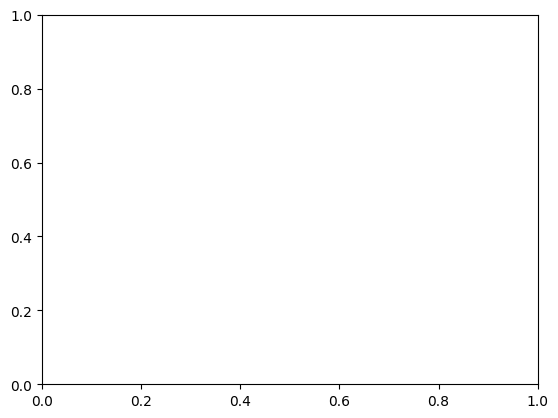

In [10]:
plt.plot(distances, exact_energies, label="Exact Energy") # Can also extract the bond length from this! And it is correct! Show this.
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy (Hartree)')
plt.legend()
plt.show()